# Make predictions  

This script uses the classifiers with the highest accuracy to get the LIs and predictions for all cases

### import modules

In [1]:
%matplotlib inline

In [2]:
import os
import fnmatch

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn import preprocessing, model_selection, metrics
from nilearn import plotting

import pickle

### get absolute directory of project

In [3]:
# after converstion to .py, we can use __file__ to get the module folder
try:
    thisDir = os.path.realpath(__file__)
# in notebook form, we take the current working directory (we need to be in 'notebooks/' for this!)
except:
    thisDir = '.'
# convert relative path into absolute path, so this will work with notebooks and py modules
supDir = os.path.abspath(os.path.join(os.path.dirname(thisDir), '..'))

supDir

'/data/martin/language_lat'

In [4]:
sns.set_style('white')
sns.set_context('poster')

### load labeler

In [5]:
myLabeler = pickle.load(open('%s/models/myLabeler.p' % supDir, 'rb'))

In [6]:
myLabeler.classes_

array(['bilateral', 'inconclusive', 'left', 'right'], dtype=object)

### collect the parameters that allow for above-chance prediction

In [7]:
aboveDf = pd.read_csv('%s/models/aboveDf_clf_1d_drop.csv' % supDir,index_col=[0,1])

In [8]:
aboveDf.T

0                                                    \
Unnamed: 1       1.0       1.2       1.4      1.6       1.8       2.0   
0           0.869259  0.876991  0.883981  0.88787  0.892731  0.895093   

                                                     ...           95  \
Unnamed: 1      2.2       2.4       2.6       2.8    ...          3.8   
0           0.89875  0.901944  0.904259  0.905463    ...     0.898704   

                                                                        \
Unnamed: 1       4.0       4.2       4.4       4.6       4.8       5.0   
0           0.896296  0.895139  0.895185  0.891806  0.889167  0.878102   

                                          
Unnamed: 1       5.2       5.4       5.6  
0           0.881296  0.874491  0.876019  

[1 rows x 608 columns]

In [9]:
clfDict = pickle.load(open('%s/models/clf_1d_drop.p' % supDir))

In [14]:
clfDict[95][3-0]

{'clf': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
   max_iter=-1, probability=True, random_state=0, shrinking=True, tol=0.001,
   verbose=False),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

### predictions for one value and one parameter set

In [15]:
def makePred(x, roiPc, tThresh, clfDict, myLabeler=myLabeler):

    thisClf = clfDict[roiPc][tThresh]['clf']
    thisScaler = clfDict[roiPc][tThresh]['scaler']

    xArr = np.array(x)
    xScaled = thisScaler.transform(xArr.reshape(1, -1 * xArr.shape[-1]))

    y_pred = thisClf.predict_proba(xScaled)

    df = pd.DataFrame(y_pred).T
    idx = [myLabeler.inverse_transform([x])[-1] for x in thisClf.classes_]
    df.index = idx

    return df

Example:

In [16]:
thesePreds = makePred([0.0], 0, 3, clfDict)

In [17]:
thesePreds

,0
bilateral,0.678082
left,0.173603
right,0.148315


### predictions for one patient, for all above-chance parameters

In [18]:
def changeDf(df):

    idx1 = df.columns.get_level_values(0).astype(float)
    idx2 = df.columns.get_level_values(1)

    mIdx = pd.MultiIndex.from_arrays([idx2, idx1])

    df.columns = mIdx
    df.sort_index(axis=1,inplace=True)

    return df

Example Patient:

In [19]:
pCsv = '%s/data/interim/csv/roiLaterality_pat0399_b.csv' % supDir

In [20]:
pName = 'pat_%s' % (pCsv.split('_pat')[-1].split('.')[0])
pName

'pat_0399_b'

In [21]:
pDf = pd.read_csv(pCsv, index_col=[0], header=[0, 1])
pDf = changeDf(pDf)

In [22]:
pDf.tail()

L+R                                                              \
       -10.0     -9.9      -9.8      -9.7      -9.6      -9.5      -9.4    
75  1.997967  1.997629  1.997241  1.996757  1.996564  1.995886  1.995256   
80  1.998431  1.998189  1.998008  1.997646  1.997464  1.996920  1.996498   
85  1.999438  1.999277  1.999277  1.999035  1.998955  1.998471  1.998069   
90  2.000000  2.000000  2.000000  1.999879  1.999879  1.999516  1.999395   
95  2.000000  2.000000  2.000000  2.000000  2.000000  1.999516  1.999274   

                                  ...     LI                                \
       -9.3      -9.2      -9.1   ...   19.0  19.1  19.2  19.3  19.4  19.5   
75  1.994966  1.994627  1.994240  ...    NaN   NaN   NaN   NaN   NaN   NaN   
80  1.996256  1.996075  1.995712  ...    NaN   NaN   NaN   NaN   NaN   NaN   
85  1.997908  1.997828  1.997586  ...    NaN   NaN   NaN   NaN   NaN   NaN   
90  1.999395  1.999395  1.999274  ...    NaN   NaN   NaN   NaN   NaN   NaN   
95  1.999274  1.999274  1.999032  ...    NaN   NaN   NaN   NaN   NaN   NaN   

                            
    19.6  19.7  19.8  19.9  
75   NaN   NaN   NaN   NaN  
80   NaN   NaN   NaN   NaN  
85   NaN   NaN   NaN   NaN  
90   NaN   NaN   NaN   NaN  
95   NaN   NaN   NaN   NaN  

[5 rows x 900 columns]

In [23]:
def getP(pDf, pName, roiSize, thresh, dims, myLabeler=myLabeler):

    if dims == 1:
        liValue = pDf.loc[roiSize, 'LI'].loc[thresh]
        thisDf = pd.DataFrame([liValue], index=[pName], columns=['LI'])

    elif dims == 2:
        diffValue = pDf.loc[roiSize, 'L-R'].loc[thresh]
        diffDf = pd.DataFrame([diffValue], index=[pName], columns=['L-R'])

        addValue = pDf.loc[roiSize, 'L+R'].loc[thresh]
        addDf = pd.DataFrame([addValue], index=[pName], columns=['L+R'])

        thisDf = pd.concat([diffDf, addDf], axis=1)

    return thisDf

In [ ]:
getP(pDf, pName, roiSize=50, thresh=5.8, dims=1)

In [25]:
def makeBestPreds(pCsv, aboveDf, clfDict, dims):

    pName = 'pat_%s' % (pCsv.split('_pat')[-1].split('.')[0])
    pDf = pd.read_csv(pCsv, index_col=[0], header=[0, 1])
    pDf = changeDf(pDf)
    
    valueDict = {}
    predDf = pd.DataFrame()

    # here we loop through the aboveDf, which has in its index
    # all parameters that we want

    # get the table with the roi size
    for pc in aboveDf.index.levels[0]:
        # get the data for the threshold
        for t in aboveDf.loc[pc].index:

            thisParam = getP(pDf, pName, pc, t, dims)

            # store the value
            thisVals = list(thisParam.loc[pName])
            valueDict[str(pc) + '_' + str(t)] = thisVals

            # make predictions, these are like df's
            try:
                thisPred = makePred(thisVals, pc, t, clfDict)
            except:
                thisPred = pd.DataFrame({
                    'bilateral': 0,
                    'left': 0,
                    'right': 0,
                    'inconclusive': 1
                },
                                        index=[0]).T
            #store predictions
            thisPred = thisPred.T
            thisPred.index = [str(pc) + '_' + str(t)]
            predDf = pd.concat([predDf, thisPred])

    if dims == 1:
        valueDf = pd.DataFrame(valueDict, index=['LI']).T
    elif dims == 2:
        valueDf = pd.DataFrame(valueDict, index=['L-R', 'L+R']).T

    # average
    
    meanValueDf = pd.DataFrame(valueDf.mean())
    meanPredDf = pd.DataFrame(predDf.mean())
    
    meanDf = pd.concat([meanValueDf,meanPredDf]).T
    meanDf.index = [pName]

    return valueDf, predDf, meanDf

Example:

In [26]:
valueDf, predDf, meanDf = makeBestPreds(pCsv, aboveDf, clfDict, dims=1)

In [ ]:
meanDf

In [28]:
fuDf = predDf.copy()
fuDf.index = pd.MultiIndex.from_tuples(list([x.split('_') for x in fuDf.index]))

In [29]:
def changeIdx(df):

    idx1 = df.index.get_level_values(0).astype(int)
    idx2 = df.index.get_level_values(1).astype(float)

    mIdx = pd.MultiIndex.from_arrays([idx2, idx1])

    df.index = mIdx
    df.sort_index(axis=0,inplace=True)

    return df

In [30]:
fuDf = changeIdx(fuDf)

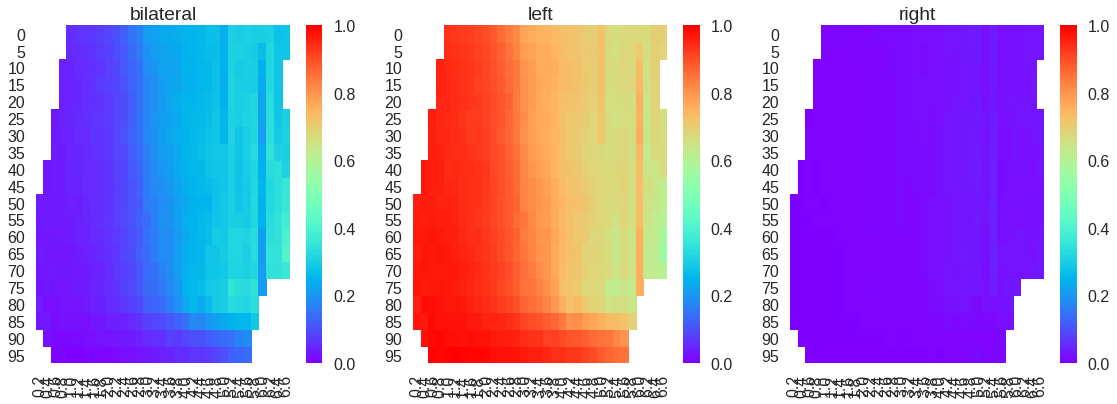

In [31]:
fig = plt.figure(figsize=(16,6))
for i,c in enumerate(fuDf.columns):
    ax = plt.subplot(1,fuDf.columns.shape[-1],i+1)
    thisDf = fuDf.loc[:,[c]].unstack()[c].T
    sns.heatmap(thisDf,cmap='rainbow',vmin=0,vmax=1,axes=ax)
    ax.set_title(c)
plt.tight_layout()
plt.show()

In [32]:
def makeAllComputations(pCsv, dims, drop, sigLevel=0.001):

    dropStr = ['full', 'drop'][drop]
    dimStr = ['1d', '2d'][dims - 1]

    # load the classifier
    clfDict = pickle.load(
        open('%s/models/clf_%s_%s.p' % (supDir, dimStr, dropStr), 'rb'))

    accDict = pickle.load(
        open('%s/models/acc_%s_%s.p' % (supDir, dimStr, dropStr), 'rb'))

    aboveDf = pd.read_csv(
        '%s/models/aboveDf_clf_%s_%s.csv' % (supDir, dimStr, dropStr),
        index_col=[0, 1])

    # compute
    valueDf, predDf, meanDf = makeBestPreds(pCsv, aboveDf, clfDict, dims=dims)

    # if we compute the 1-dimensional LI and do not want to model inconclusive cases,
    # we still need to handle cases where division by zero occurs
    # therefore, we compute the proportion of cases where neither of the 3 main classes was predicted
    if dims == 1 and drop == True:
        meanDf.loc[:,'inconclusive'] = 1 - meanDf.loc[:,['left','bilateral','right']].sum(axis=1)
    
    return valueDf, predDf, meanDf

In [33]:
valueDf, predDf, meanDf = makeAllComputations(pCsv, dims=2, drop=True)

In [36]:
valueDf.tail()

,L-R,L+R
95_4.6,0.138883,0.215359
95_4.8,0.126411,0.195627
95_5.0,0.115378,0.178301
95_5.2,0.100735,0.158818
95_5.4,0.093298,0.147509


In [37]:
predDf.tail()

,bilateral,left,right
95_4.6,0.114872,0.873428,0.011700
95_4.8,0.116585,0.868716,0.014699
95_5.0,0.119471,0.864331,0.016198
95_5.2,0.135807,0.842319,0.021874
95_5.4,0.142134,0.833325,0.024541


In [ ]:
meanDf

### do all variations

In [39]:
from datetime import datetime

In [40]:
def makeP(pCsv):

    pName = 'pat%s' % (pCsv.split('_pat')[-1].split('.')[0])

    bigDf = pd.DataFrame()

    for myDim in [1, 2]:
        for myDrop in [True, False]:

            dimStr = ['1d', '2d'][myDim - 1]
            dropStr = ['full', 'drop'][myDrop]
            #print myDim, myDrop, datetime.now()

            valueDf, predDf, meanDf = makeAllComputations(
                pCsv, dims=myDim, drop=myDrop)

            valueDf.to_csv('%s/data/processed/csv/values_%s_%s_%s.csv' %
                           (supDir, pName, dimStr, dropStr))
            predDf.to_csv('%s/data/processed/csv/predictions_%s_%s_%s.csv' %
                          (supDir, pName, dimStr, dropStr))

            meanDf.index = pd.MultiIndex.from_arrays([[dimStr], [dropStr]])
            bigDf = pd.concat([bigDf, meanDf])

    bigDf.to_csv('%s/data/processed/csv/meanTable_%s.csv' % (supDir, pName))

    return bigDf

In [41]:
#def makeP(pFolder, pName):
#
#    pCsv = '%s/roiLaterality_%s.csv' % (pFolder, pName)
#
#    bigDf = pd.DataFrame()
#
#    for myDim in [2]:
#        for myDrop in [False]:
#
#            dimStr = ['1d', '2d'][myDim - 1]
#            dropStr = ['full', 'drop'][myDrop]
#
#            valueDf, predDf, meanDf = makeAllComputations(
#                pCsv, dims=myDim, drop=myDrop)
#
#            valueDf.to_csv(
#                '%s/values_%s_%s_%s.csv' % (pFolder, pName, dimStr, dropStr))
#            predDf.to_csv('%s/predictions_%s_%s_%s.csv' % (pFolder, pName,
#                                                           dimStr, dropStr))
#
#            meanDf.index = pd.MultiIndex.from_arrays([[dimStr], [dropStr]])
#            bigDf = pd.concat([bigDf, meanDf])
#
#    bigDf.to_csv('%s/meanTable_%s.csv' % (pFolder, pName))
#
#    return bigDf

In [42]:
meanDf = makeP(pCsv)

In [ ]:
meanDf

## do this for all patients

### collect all patients

In [44]:
my_train = pickle.load(open('../models/my_nest.p', 'rb'))
my_test = pickle.load(open('../models/my_test.p', 'rb'))
my_all = my_train + my_test
len(my_all)

783

In [45]:
csvList = [
    '../data/interim/csv/%s' % x for x in os.listdir('../data/interim/csv/')
    if x.startswith('roiLaterality_pat')
]
csvList.sort()

In [48]:
def makeDf(csvList,trainOrTest):
    df = pd.DataFrame()
    for pat in csvList:
        for lab in trainOrTest:
            if lab[-1] in pat:
                thisDf = pd.DataFrame([pat], index=[[lab[0]], [lab[1]]])
                df = pd.concat([df, thisDf])
    df.columns = ['csv']

    df.sort_index(inplace=True)
    return df

In [49]:
dfAll = makeDf(csvList,trainOrTest=my_all)

In [50]:
dfAll.shape

(783, 1)

In [ ]:
dfAll.tail()

### run for all patients

In [58]:
doneList = [
    x.split('meanTable_')[-1].split('.')[0]
    for x in os.listdir('%s/data/processed/csv/' % supDir)
    if x.startswith('meanTable_')
]
len(doneList)

783

In [61]:
for p in dfAll.index:
    if p[1] not in doneList:
        pCsv = dfAll.loc[p,'csv']
        print datetime.now(),pCsv
        meanDf = makeP(pCsv)